______________________________________________________________
# DATA ANALYSIS & AI/OPTIMIZATION PROJECT - Features Selection

______________________________________________________________

In [2]:
# System imports
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import datetime
import scipy.ndimage as ndi
import pandas as pd
import cv2

!pip install opencv-python-headless
!pip install joblib

from skimage import io, measure
from sklearn.cluster import KMeans
from time import process_time
from PIL import Image, ImageOps
from scipy.optimize import minimize
from scipy.ndimage import rotate
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [3]:
directory_path1="./Images - without 154"
images_paths = glob.glob(os.path.join(directory_path1, '*.tif'))
directory_path2="./train/masks"
mask_paths = glob.glob(os.path.join(directory_path2, '*.tif'))
ds1 = pd.read_excel("C:/Users/david/Downloads/ADD/Projet ADD/ds1.xlsx", sheet_name='Feuil1', usecols=['ID', 'Symmetry Index'], index_col=0)
ds2 = pd.read_excel("C:/Users/david/Downloads/ADD/Projet ADD/ds2.xlsx", sheet_name='Tabelle1', usecols=['ID', 'Symmetry Index','Aspect Ratio'], index_col=0)
ds3 = pd.read_excel("C:/Users/david/Downloads/ADD/Projet ADD/ds3.xlsx", sheet_name='Tabelle1', usecols=['ID', 'Symmetry Index','Aspect Ratio','Pixel Ratio'], index_col=0)

# 1) Symmetry Index

In this first part, we create a code that computes the symmetry indexes of every masks. To do so, we first write a couple of functions useful for what's to come. We then create a dataframe by using all those previous functions and we verify the returned dataframe composed of all the mask indexes and corresponding symmetry indexes.

## 1.1 Defining functions

- load_mask : used to load the mask images as arrays. It takes a give mask path and returns a array of it.

In [8]:
def load_mask(mask_path):
    mask = Image.open(mask_path).convert('L') #first we convert the mask to grayscale
    mask = np.array(mask) #then we create an array for the mask
    return mask // 255 #finally we return the mask

- find_centroid : this function is used to find the centroid of each mask, this is useful in order to find the symmetry axis. It takes a given mask (as an array) and returns the centroid coordinates.

In [10]:
def find_centroid(mask):
    # Find the coordinates of non-zero (white) pixels
    y, x = np.nonzero(mask)
    # Calculate the mean coordinates (centroid)
    centroid_x = np.mean(x)
    centroid_y = np.mean(y)
    return int(centroid_x), int(centroid_y)

- rotate_image : this function is used to rotate the image in order to find the best symmetry index. It takes an image (here a mask), an angle and centroid coordinates and returns a new image.

In [12]:
def rotate_image(image, theta_degree, xc, yc):
    """ Rotation of angle theta_degree around center (xc, yc) of a binary image """
    # Convert the angle into radian
    theta = np.radians(theta_degree)
    # Image size
    s1, s2 = image.shape
    # Get all the pixels in the input array
    y, x = np.indices((s1, s2))
    # Compute the coordinates obtained after rotation
    xr = np.cos(theta) * (x - xc) - np.sin(theta) * (y - yc) + xc
    yr = np.sin(theta) * (x - xc) + np.cos(theta) * (y - yc) + yc
    # Initialize the rotation array (binary image)
    rot_arr = np.zeros_like(image)
    # Round coordinates and filter valid ones
    xr = np.round(xr).astype(int)
    yr = np.round(yr).astype(int)
    valid_mask = (xr >= 0) & (xr < s2) & (yr >= 0) & (yr < s1)
    rot_arr[yr[valid_mask], xr[valid_mask]] = image[y[valid_mask], x[valid_mask]]
    return rot_arr

- caculate_symmetry_index : this is the key function here, it works by splitting the mask into 2 halfs (left and right) and flips the right halft horizontally in order to compare both halves and define a symmetry index based on the differences. It takes a mask and a centroid and returns an index.

In [14]:
def calculate_symmetry_index(mask, centroid_x):
    # Split the mask into left and right halves at the centroid_x
    left_half = mask[:, :centroid_x]
    right_half = mask[:, centroid_x:]
    
    # If the halves have different widths, adjust the right half
    if left_half.shape[1] > right_half.shape[1]:
        left_half = left_half[:, :right_half.shape[1]]
    elif right_half.shape[1] > left_half.shape[1]:
        right_half = right_half[:, :left_half.shape[1]]

    # Flip the right half horizontally
    right_half = np.fliplr(right_half)
    
    # Calculate the absolute difference between the left and right halves
    difference = np.abs(left_half - right_half)
    
    # Sum the differences to get total difference score
    symmetry_score = np.sum(difference)
    
    # Normalize the score by the total number of pixels in the halves
    total_pixels = np.product(left_half.shape)
    symmetry_index = symmetry_score / total_pixels
    
    # Return the symmetry index where 1 means perfectly symmetrical
    return 1 - symmetry_index

- find_best_symmetry : this function takes a couple of previous functions. For a mask, it calculates its centroid and for a large number of angles (37), it rotates the image and calculates the symmetry index every time. It then finds the highest one. It takes a mask and returns its best symmetry.

In [16]:
def find_best_symmetry(mask):
    centroid_x, centroid_y = find_centroid(mask)
    best_symmetry_index = 0
    best_angle = 0
    
    for angle in range(-90, 91, 5):  # Test angles from -90 to 90 degrees in 5-degree increments
        rotated_mask = rotate_image(mask, angle, centroid_x, centroid_y)
        symmetry_index = calculate_symmetry_index(rotated_mask, centroid_x)
        if symmetry_index > best_symmetry_index:
            best_symmetry_index = symmetry_index
            best_angle = angle

    return best_symmetry_index

## 1.2 Creating the proper dataframe

We now execute a code that will load all the masks, find the best symmetry index every time and return the dataframe with all the mask indexes and the corresponding symmetry index.

In [19]:
results = [] # Initialize a list for the values

for mask_path in mask_paths: # For every mask
    mask = load_mask(mask_path) # Load the mask
    best_symmetry_index = find_best_symmetry(mask) # Find the best symmetry of the mask
    image_index = int(os.path.basename(mask_path).split('_')[1].split('.')[0]) # Create a mask image based on the name
    results.append({'Image Index': image_index, 'Symmetry Index': best_symmetry_index}) # Add the mask index and the best symmetry index

df = pd.DataFrame(results) # Create the dataframe with all values
df.set_index('Image Index', inplace=True) # Set the mask index as the index
df.sort_index(inplace=True) # Sort the list

In [20]:
df

,Symmetry Index
Image Index,
1,0.173222
2,0.196968
3,0.000000
4,0.000000
5,0.368057
...,...
246,0.000000
247,0.000000
248,0.412942


We then take a look at the dataframe by describing it.

In [22]:
df.describe()

,Symmetry Index
count,249.000000
mean,0.091938
std,0.185804
min,0.000000
25%,0.000000
50%,0.000000
75%,0.073261
max,0.891982


We then look at the masks with the highest and lowest symmetry indexes in order to make sure our code works reasonably well.

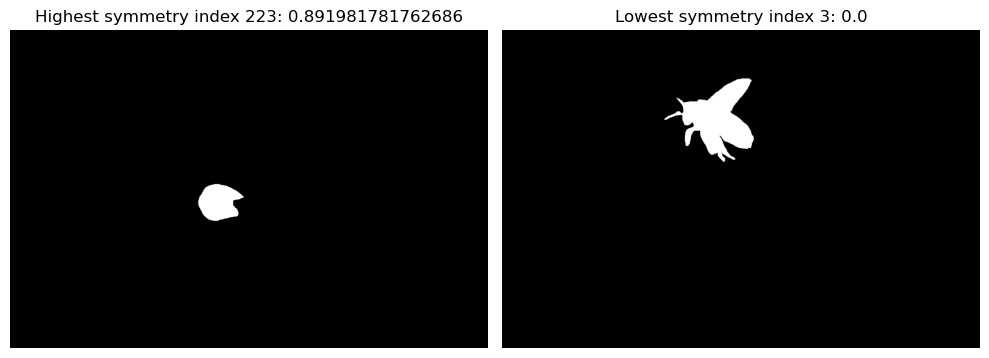

In [24]:
# Find the image index with the highest symmetry index
max_sym_index = df['Symmetry Index'].idxmax()
# Find the image index with the lowest symmetry index
min_sym_index = df['Symmetry Index'].idxmin()

# Display images with the highest and lowest ratio
plt.figure(figsize=(10, 5))
    
# High ratio
image_path_high = os.path.join(directory_path2, f'binary_{max_sym_index}.tif')
image_high = Image.open(image_path_high)
plt.subplot(1, 2, 1)
plt.imshow(image_high, cmap='gray')
plt.title(f'Highest symmetry index {max_sym_index}: {df.loc[max_sym_index, "Symmetry Index"]}')
plt.axis('off')
    
# Low ratio
image_path_low = os.path.join(directory_path2, f'binary_{min_sym_index}.tif')
image_low = Image.open(image_path_low)
plt.subplot(1, 2, 2)
plt.imshow(image_low, cmap='gray')
plt.title(f'Lowest symmetry index {min_sym_index}: {df.loc[min_sym_index, "Symmetry Index"]}')
plt.axis('off')
    
plt.tight_layout()
plt.show()

# 2) Aspect ratio


Now that we've got the symmetry indexes of every mask, we will now calculate the aspect ratio of each mask. To do so, we first establish functions to use. We then create the proper dataframe and verify it.

## 2.1 Defining functions

- find_longest_line : used to find the longest continous line of white pixels in a mask. It takes a mask and returns the length, coordinates and axis of the longest line that crosses the bug

In [29]:
def find_longest_line(mask):
    centroid_x, centroid_y = find_centroid(mask)
    max_length = 0
    max_coords = None
    max_axis = None
    
    for angle in range(-90, 91, 5):  # Test angles from -90 to 90 degrees in 5-degree increments
        rotated_mask = rotate_image(mask, angle, centroid_x, centroid_y)
        # Check horizontal lines
        for y in range(mask.shape[0]):
            row = mask[y, :]
            non_zero_indices = np.where(row > 0)[0]
            if len(non_zero_indices) > 0:
                length = non_zero_indices[-1] - non_zero_indices[0] + 1
                if length > max_length:
                    max_length = length
                    max_coords = ((y, non_zero_indices[0]), (y, non_zero_indices[-1]))
                    max_axis = 'horizontal'

        # Check vertical lines
        for x in range(mask.shape[1]):
            col = mask[:, x]
            non_zero_indices = np.where(col > 0)[0]
            if len(non_zero_indices) > 0:
                length = non_zero_indices[-1] - non_zero_indices[0] + 1
                if length > max_length:
                    max_length = length
                    max_coords = ((non_zero_indices[0], x), (non_zero_indices[-1], x))
                    max_axis = 'vertical'
    
    return max_length, max_coords, max_axis

- rotate_mask : this function is used to rotate the image in order to find the best symmetry index. It takes an image (here a mask), coordinates and an axis and returns the rotated mask. Its approach is different from the prievous rotate_image because of how it is implemented.

In [31]:
def rotate_mask(mask, coords, axis):
    if axis == 'horizontal':
        y1, x1 = coords[0]
        y2, x2 = coords[1]
        angle = np.degrees(np.arctan2(y2 - y1, x2 - x1))
    else:
        y1, x1 = coords[0]
        y2, x2 = coords[1]
        angle = np.degrees(np.arctan2(x2 - x1, y2 - y1))
    
    rotated_mask = rotate(mask, angle, reshape=True, order=0)
    return rotated_mask

- find_orthogonal_line : this function finds the longest line orthogonal to a given line. It takes a mask, the coordinates of a line and an axis and returns the length of the longest orthogonal line.

In [33]:
def find_orthogonal_longest_line(mask, longest_coords, axis):
    rotated_mask = rotate_mask(mask, longest_coords, axis)
    
    if axis == 'horizontal':
        orthogonal_axis = 'vertical'
    else:
        orthogonal_axis = 'horizontal'
    
    max_length = 0
    max_coords = None
    
    # Check orthogonal lines in the rotated mask
    if orthogonal_axis == 'vertical':
        for x in range(rotated_mask.shape[1]):
            col = rotated_mask[:, x]
            non_zero_indices = np.where(col > 0)[0]
            if len(non_zero_indices) > 0:
                length = non_zero_indices[-1] - non_zero_indices[0] + 1
                if length > max_length:
                    max_length = length
                    max_coords = ((non_zero_indices[0], x), (non_zero_indices[-1], x))
    else:
        for y in range(rotated_mask.shape[0]):
            row = rotated_mask[y, :]
            non_zero_indices = np.where(row > 0)[0]
            if len(non_zero_indices) > 0:
                length = non_zero_indices[-1] - non_zero_indices[0] + 1
                if length > max_length:
                    max_length = length
                    max_coords = ((y, non_zero_indices[0]), (y, non_zero_indices[-1]))
    
    return max_length

- calculate_line_ratios : this function takes the 2 longest orthogonal lines and returns the ratio of the smallest divided by the longest of the 2

In [35]:
def calculate_line_ratios(mask):
    longest_length, longest_coords, axis = find_longest_line(mask)
    orthogonal_length = find_orthogonal_longest_line(mask, longest_coords, axis)
    
    if longest_length == 0 or orthogonal_length == 0:
        return np.nan 
    
    return min(longest_length, orthogonal_length) / max(longest_length, orthogonal_length)

## 2.2 Creating the proper dataframe

We now execute a code that will load all the masks, find the line ratio every time and return the dataframe with all the mask indexes and the corresponding line ratios.

In [38]:
results = []
mask_filenames = sorted([f for f in os.listdir(directory_path2) if f.endswith('.tif')], key=lambda x: int(x.split('_')[1].split('.')[0]))

for mask_filename in mask_filenames:
    mask_path = os.path.join(directory_path2, mask_filename)
    mask = load_mask(mask_path)
    if mask is not None:
        line_ratio = calculate_line_ratios(mask)
        image_index = int(os.path.basename(mask_path).split('_')[1].split('.')[0])
        results.append({'Image Index': image_index, 'Line Ratio': line_ratio})
    else:
        print(f"Mask not found or corrupt: {mask_path}")
        
results_df = pd.DataFrame(results)
results_df.set_index('Image Index', inplace=True)
results_df.sort_index(inplace=True)

df = df.merge(results_df, left_index=True, right_index=True, how='left')

In [39]:
df

,Symmetry Index,Line Ratio
Image Index,,
1,0.173222,0.891304
2,0.196968,0.823529
3,0.000000,0.967742
4,0.000000,0.672840
5,0.368057,0.775140
...,...,...
246,0.000000,0.862712
247,0.000000,0.837349
248,0.412942,0.833581


We then take a look at the dataframe by describing it.

In [41]:
df.describe()

,Symmetry Index,Line Ratio
count,249.000000,249.000000
mean,0.091938,0.807795
std,0.185804,0.132570
min,0.000000,0.319149
25%,0.000000,0.735174
50%,0.000000,0.831204
75%,0.073261,0.914474
max,0.891982,1.000000


We then look at the masks with the highest and lowest line ratios in order to make sure our code works reasonably well.

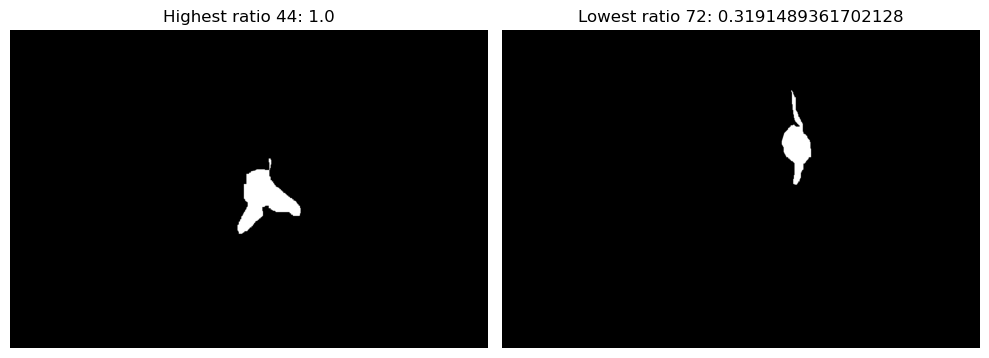

In [43]:
# Find the image index with the highest ratio
max_ratio = df['Line Ratio'].idxmax()
# Find the image index with the lowest ratio
min_ratio = df['Line Ratio'].idxmin()

# Display images with the highest and lowest ratio
plt.figure(figsize=(10, 5))
    
# High ratio
image_path_high = os.path.join(directory_path2, f'binary_{max_ratio}.tif')
image_high = Image.open(image_path_high)
plt.subplot(1, 2, 1)
plt.imshow(image_high, cmap='gray')
plt.title(f'Highest ratio {max_ratio}: {df.loc[max_ratio, "Line Ratio"]}')
plt.axis('off')
    
# Low ratio
image_path_low = os.path.join(directory_path2, f'binary_{min_ratio}.tif')
image_low = Image.open(image_path_low)
plt.subplot(1, 2, 2)
plt.imshow(image_low, cmap='gray')
plt.title(f'Lowest ratio {min_ratio}: {df.loc[min_ratio, "Line Ratio"]}')
plt.axis('off')
    
plt.tight_layout()
plt.show()

# 3) Pixel Ratio

This code's goal is to display :
- a list of the pixel ratios, ratios and symmetry indexes for every images indexes
- a description of this list
- the images with the highest and lowest pixel ratio

### 3.1 Writing the functions to measure the number of pixels

In [47]:
def measure_pixels(image_path):
    image = Image.open(image_path)  
    width, height = image.size
    return width * height

In [48]:
def measure_pixels_mask(image_path):
    mask = Image.open(image_path).convert('L')
    mask_array = np.array(mask)
    return np.sum(mask_array == 255)

### 3.2 Adding the pixel ratios to the dataframe

In [50]:
# Dictionaries to store pixel counts
pixels_image = {}
pixels_mask = {}

# Collect pixel counts for each image
for image_path in glob.glob(os.path.join(directory_path1, '*.JPG')):
    num_pixels1 = measure_pixels(image_path)
    image_index = int(os.path.basename(image_path).split('.')[0]) 
    pixels_image[image_index] = num_pixels1
        
# Collect pixel counts for each mask
for image_path in glob.glob(os.path.join(directory_path2, '*.tif')):
    num_pixels2 = measure_pixels_mask(image_path)
    image_index = int(os.path.basename(image_path).split('_')[1].split('.')[0]) 
    pixels_mask[image_index] = num_pixels2

# Create Pixel Ratio column
df['Pixel Ratio'] = [pixels_mask[idx] / pixels_image[idx] if idx in pixels_image and idx in pixels_mask else None for idx in df.index]

In [51]:
df

,Symmetry Index,Line Ratio,Pixel Ratio
Image Index,,,
1,0.173222,0.891304,0.006951
2,0.196968,0.823529,0.008023
3,0.000000,0.967742,0.021430
4,0.000000,0.672840,0.012538
5,0.368057,0.775140,0.008745
...,...,...,...
246,0.000000,0.862712,0.006250
247,0.000000,0.837349,0.020050
248,0.412942,0.833581,0.007032


In [52]:
df.describe()

,Symmetry Index,Line Ratio,Pixel Ratio
count,249.000000,249.000000,249.000000
mean,0.091938,0.807795,0.022883
std,0.185804,0.132570,0.016881
min,0.000000,0.319149,0.003460
25%,0.000000,0.735174,0.013245
50%,0.000000,0.831204,0.020054
75%,0.073261,0.914474,0.028377
max,0.891982,1.000000,0.187458


# 4) Bounding box

In [54]:
def compute_bounding_box_ratio(mask_arr):
    # Find the coordinates of the non-zero points (the bug)
    y_indices, x_indices = np.nonzero(mask_arr)

    # Compute the bounding box coordinates
    min_x, max_x = np.min(x_indices), np.max(x_indices)
    min_y, max_y = np.min(y_indices), np.max(y_indices)
    
    # Create the bounding box array
    bounding_box = np.zeros_like(mask_arr)
    bounding_box[min_y:max_y+1, min_x:max_x+1] = 1

    # Calculate the proportion of the bug inside the bounding box
    bug_area = np.sum(mask_arr)
    bounding_box_area = np.sum(bounding_box)
    ratio = bug_area / bounding_box_area

    return ratio

In [55]:
def find_optimal_rotation(mask_arr):
    best_ratio = 0
    for angle in range(-90, 90, 5): 
        rotated_mask = rotate_image(mask_arr, angle, xc=mask_arr.shape[1]//2, yc=mask_arr.shape[0]//2)
        ratio = compute_bounding_box_ratio(rotated_mask)
        if ratio > best_ratio:
            best_ratio = ratio
    return best_ratio

In [56]:
results = []

# Sort mask filenames based on image index
mask_filenames = sorted([f for f in os.listdir(directory_path2) if f.endswith('.tif')], key=lambda x: int(x.split('_')[1].split('.')[0]))

# Iterate through each mask file
for mask_filename in mask_filenames:
    mask_path = os.path.join(directory_path2, mask_filename)
    mask_arr = load_mask(mask_path)
    bounding_box_proportion = compute_bounding_box_ratio(mask_arr)
    image_index = int(mask_filename.split('_')[1].split('.')[0])
    results.append({'Image Index': image_index, 'Bounding Box Proportion': bounding_box_proportion})

results_df = pd.DataFrame(results)
results_df.set_index('Image Index', inplace=True)
results_df.sort_index(inplace=True)

df = df.merge(results_df, left_index=True, right_index=True, how='left')

In [57]:
df

,Symmetry Index,Line Ratio,Pixel Ratio,Bounding Box Proportion
Image Index,,,,
1,0.173222,0.891304,0.006951,0.485305
2,0.196968,0.823529,0.008023,0.412341
3,0.000000,0.967742,0.021430,0.438176
4,0.000000,0.672840,0.012538,0.412787
5,0.368057,0.775140,0.008745,0.382750
...,...,...,...,...
246,0.000000,0.862712,0.006250,0.468131
247,0.000000,0.837349,0.020050,0.449497
248,0.412942,0.833581,0.007032,0.383151


______________________________________________________________
# DATA ANALYSIS & AI/OPTIMIZATION PROJECT - Data Visualisation
______________________________________________________________

In [59]:
# System imports
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import datetime
from time import process_time

# Extra library imports
from PIL import Image
from scipy.optimize import minimize
import scipy.ndimage as ndi
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.graph_objects as go

## 1) Repartition of bugs and species

### 1.1 Directory for the data on bugs and species

In [62]:
directory_path="./train/classif.xlsx"

Now, let's create a dataframe for them

In [64]:
df1 = pd.read_excel(directory_path, index_col='ID')
df1

,bug type,species
ID,,
1,Bee,Apis mellifera
2,Bee,Apis mellifera
3,Bee,Apis mellifera
4,Bee,Apis mellifera
5,Bee,Apis mellifera
...,...,...
246,Bee,Apis mellifera
247,Bee,Apis mellifera
248,Bee,Apis mellifera


In [65]:
df1_without_154 = df1.drop(154)

### 1.2 Repartition of bugs

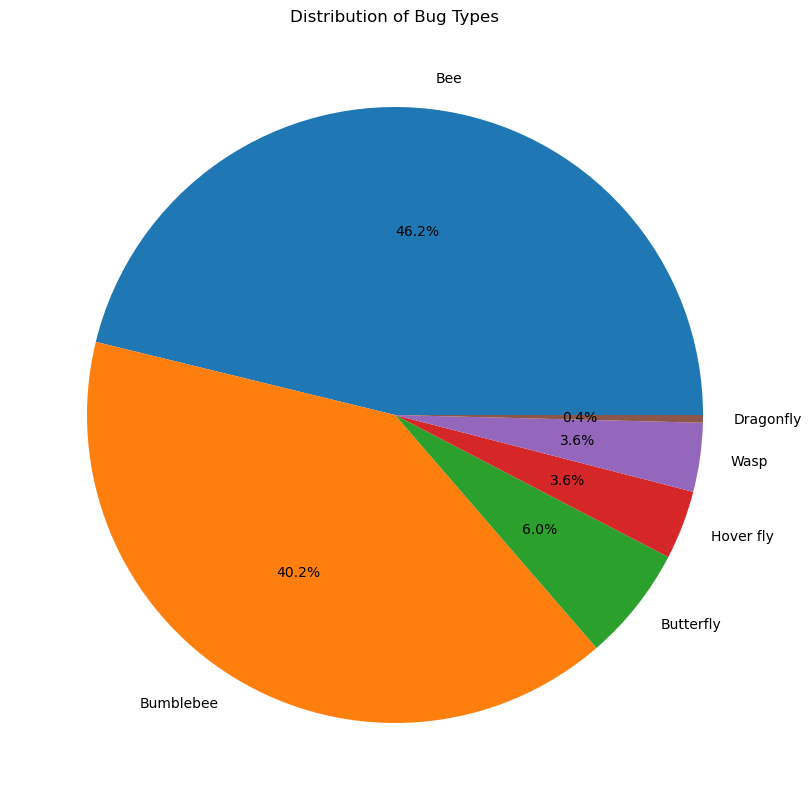

In [67]:
bug_type_counts = df1_without_154['bug type'].value_counts()
plt.figure(figsize=(10, 10))
plt.pie(bug_type_counts, labels=bug_type_counts.index, autopct='%1.1f%%')
plt.title('Distribution of Bug Types')
plt.show()

### 1.3 Repartition of species between bugs

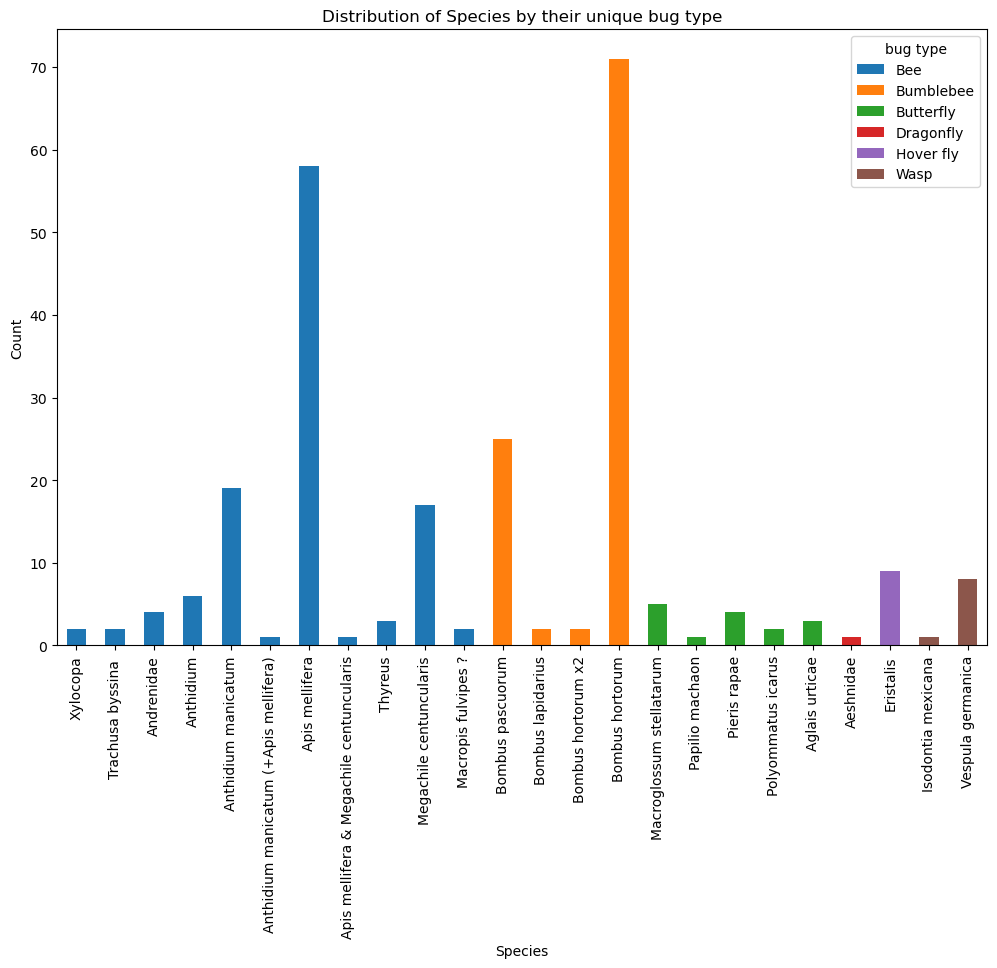

In [69]:
species_by_type = df1_without_154.groupby(['species', 'bug type']).size().unstack(fill_value=0)
species_by_type['Dominant Bug Type'] = species_by_type.idxmax(axis=1)
species_by_type.sort_values(by='Dominant Bug Type', inplace=True)
species_by_type.drop(columns='Dominant Bug Type', inplace=True)

species_by_type.plot(kind='bar', stacked=True, figsize=(12, 8))
plt.title('Distribution of Species by their unique bug type')
plt.xlabel('Species')
plt.ylabel('Count')
plt.xticks(rotation=90)  
plt.show()

## 2. PCA Projection

### 2.1 Creating the proper arrays

1 list of species

1 list of bugs

In [73]:
species = np.unique(df1_without_154["species"].values)
bug_type = np.unique(df1_without_154["bug type"].values)

### 2.2 Centering and reducing the data from Part 1

In [75]:
feat_names = df2.columns.tolist()
scaler = StandardScaler()
dfn = df2.copy()
dfn[feat_names] = scaler.fit_transform(dfn[feat_names])
dfn

NameError: name 'df2' is not defined

### 2.3 Creating 1 larger dataframe df2

In [ ]:
df2 = pd.concat([df2, df1_without_154], axis=1)
df2

### 2.4 PCA Algorithms

In [ ]:
pca = PCA(n_components=3)
df_pca = pca.fit_transform(dfn[feat_names])

In [ ]:
pc1 = round(pca.explained_variance_ratio_[0] * 100,2)
pc2 = round(pca.explained_variance_ratio_[1] * 100,2)
pc3 = round(pca.explained_variance_ratio_[2] * 100,2)

[pc1 , pc2, pc3]

In [ ]:
fig, ax = plt.subplots();
for bugs in bug_type:
    ax.scatter(df_pca[df2["bug type"]==bugs, 0], df_pca[df2["bug type"]==bugs, 1],label=bugs);

ax.legend();
ax.set_xlabel("PC1 ({0}% of explained variance) : Symmetry Indexes".format(pc1, fontsize=12));
ax.set_ylabel("PC2 ({0}% of explained variance) : Ratio".format(pc2, fontsize=12));
ax.set_title('PCA Projection of Symmetry Index and Ratio grouped by bug types', fontsize=12);

In [ ]:
fig, ax = plt.subplots();
for bugs in bug_type:
    ax.scatter(df_pca[df2["bug type"]==bugs, 1], df_pca[df2["bug type"]==bugs, 2],label=bugs);

ax.legend();
ax.set_xlabel("PC2 ({0}% of explained variance) : Ratio".format(pc2, fontsize=12));
ax.set_ylabel("PC3 ({0}% of explained variance) : Pixel Ratio".format(pc3, fontsize=12));
ax.set_title('PCA Projection of Ratio and Pixel Ratio grouped by bug types', fontsize=12);

In [ ]:
fig, ax = plt.subplots();
for bugs in bug_type:
    ax.scatter(df_pca[df2["bug type"]==bugs, 0], df_pca[df2["bug type"]==bugs, 2],label=bugs);

ax.legend();
ax.set_xlabel("PC1 ({0}% of explained variance) : Symmetry Indexes".format(pc1, fontsize=12));
ax.set_ylabel("PC3 ({0}% of explained variance) : Pixel Ratio".format(pc3, fontsize=12));
ax.set_title('PCA Projection of Symmetry Index and Pixel Ratio grouped by bug types', fontsize=12);